In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

Constructing the Input Data

In [2]:
# Set-Up
# N_d: number of detectors; N_t: number of times data is detected by each detector; N_p: number of pixels
# signal: data of signal (which in this case is modeled to be a sine function in each pixel)
# P: pointing matrix

N_d, N_t, N_p = 3, 150 * 50, 25

signal = [[0] for _ in range(N_p)]
for i in range(N_p):
    signal[i][0] = 5 * i * math.sin((2 * math.pi / 25) * i)
signal = np.array(signal)

P = [[0] * N_p for _ in range(N_t * N_d)]
for i in range(N_d):
    for row in range(N_t):
        for col in range(N_p):
            P[i * N_t + row][col] = 1 if ((row / 150) // 2 == col) else 0
P = np.array(P)

(25, 1)


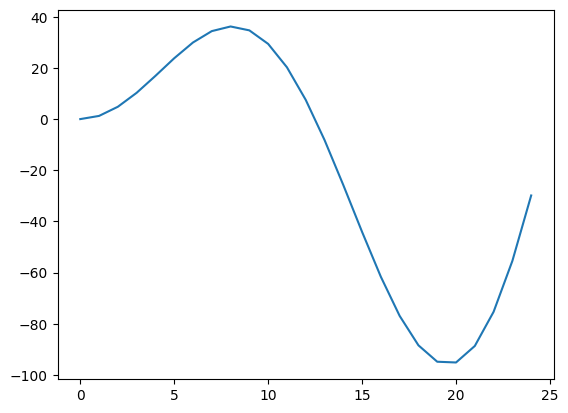

In [3]:
# check signal

print(np.shape(signal))
plt.plot(signal)

In [4]:
print(np.shape(P))

(22500, 25)


(array([0]),)
(array([0]),)
(array([1]),)
(array([1]),)
(array([24]),)
(array([0]),)
(array([0]),)
(array([1]),)
(array([1]),)
(array([24]),)
(array([0]),)
(array([0]),)
(array([1]),)
(array([1]),)
(array([24]),)


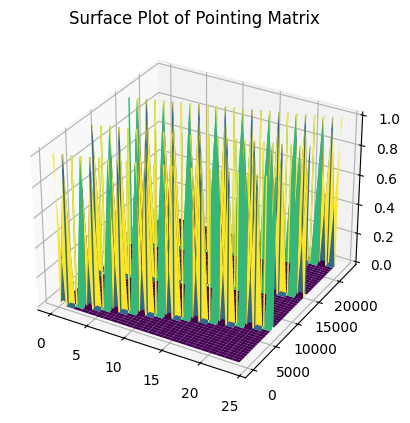

In [5]:
# check P

print(np.where(P[0] == 1))
print(np.where(P[150] == 1))
print(np.where(P[300] == 1))
print(np.where(P[301] == 1))
print(np.where(P[50 * 150 - 1] == 1))

print(np.where(P[0+N_t] == 1))
print(np.where(P[150+N_t] == 1))
print(np.where(P[300+N_t] == 1))
print(np.where(P[301+N_t] == 1))
print(np.where(P[50*150-1+N_t] == 1))

print(np.where(P[0+N_t*2] == 1))
print(np.where(P[150+N_t*2] == 1))
print(np.where(P[300+N_t*2] == 1))
print(np.where(P[301+N_t*2] == 1))
print(np.where(P[50*150-1+N_t*2] == 1))

from mpl_toolkits.mplot3d import Axes3D

x = np.arange(P.shape[1])
y = np.arange(P.shape[0])
x, y = np.meshgrid(x, y)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, P, cmap='viridis')
ax.set_title("Surface Plot of Pointing Matrix")
plt.show()

In [6]:
input = P @ signal
print(np.shape(input))

(22500, 1)


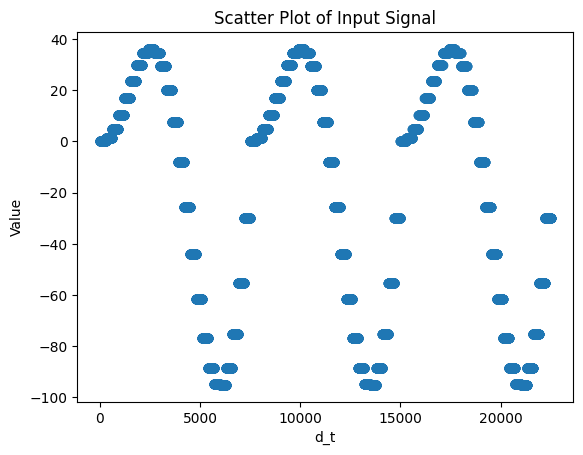

In [7]:
# Scatter Plot of Input Signal

plt.scatter(range(len(input)), input)
plt.xlabel("d_t")
plt.ylabel("Value")
plt.title("Scatter Plot of Input Signal")
plt.show()

Add White, Gaussian Noise to Data Stream

In [8]:
# Creating noisy data

N = N_t
noise_1 = np.random.randn(N) * 10
noise_2 = np.random.randn(N) * 10
noise_3 = np.random.randn(N) * 10

# Check the mean and variance
print(np.shape(noise_1))
print("Mean:", np.mean(noise_1))
print("Variance:", np.var(noise_1))

noise = np.concatenate([noise_1, noise_2, noise_3])
noise = noise.reshape(-1,1)
print(np.shape(noise))

Data = input + noise


(7500,)
Mean: -0.09913941897244323
Variance: 96.30449476939582
(22500, 1)


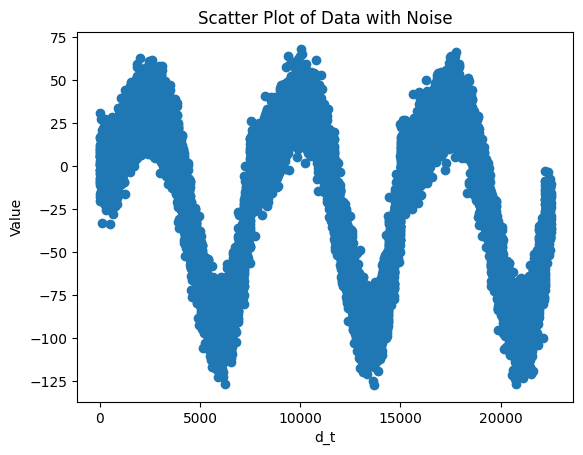

In [9]:
# Scatter Plot of Data

plt.scatter(range(len(Data)), Data)
plt.xlabel("d_t")
plt.ylabel("Value")
plt.title("Scatter Plot of Data with Noise")
plt.show()

Text(0.5, 1.0, 'Regular Plot of Data with Noise')

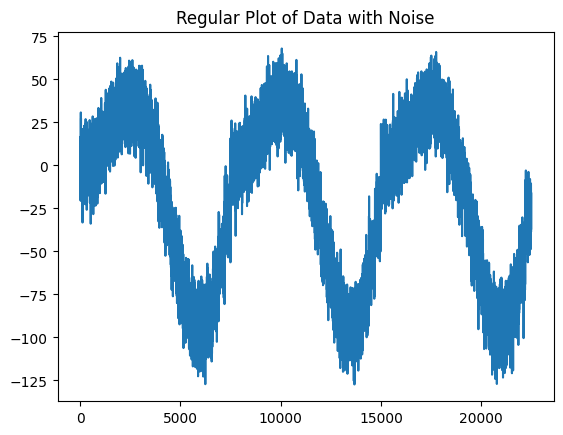

In [10]:

plt.plot(Data)
plt.title("Regular Plot of Data with Noise")

Extracting Signal from the Data when Noise is White

In [11]:
# Covariance matrix set to N_t-th identity matrix

cov_inv = (1 / np.var(noise)) * np.eye(N_t*N_d)

In [12]:
# esitmation of signal

intermediate = P.T @ cov_inv

signal_est = np.linalg.inv(intermediate @ P) @ (intermediate @ Data)

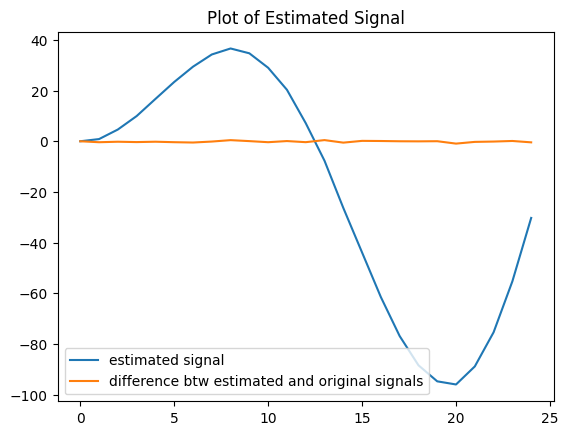

In [13]:
# Compare estimates signal with original signal

plt.plot(signal_est, label = "estimated signal")
comp = signal_est - signal
plt.plot(comp, label = "difference btw estimated and original signals")
plt.title("Plot of Estimated Signal")
plt.legend()

Text(0.5, 1.0, 'Difference btw Estimated and Original Signals')

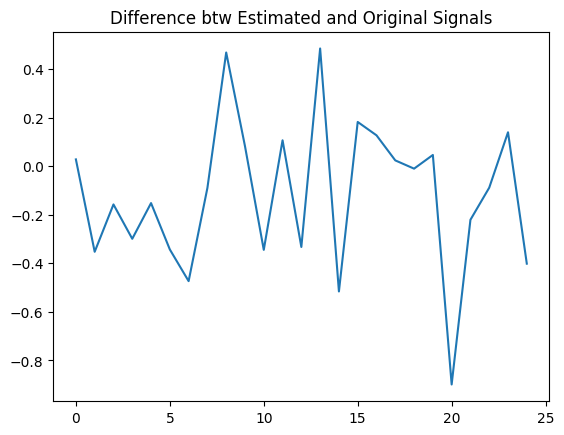

In [14]:
comp = signal_est - signal
plt.plot(comp)
plt.title("Difference btw Estimated and Original Signals")